## Introduction
-----

In this assignment you will be recursively estimating a vehicle trajectory using available measurements and motion model. 

The vehicle is equipped with a LIDAR sensor, which returns range and bearing measurements corresponding to individual landmarks in the environment. The correspondences between landmarks and their global positions are assumed to be known beforehand. We also assume knowledge about which measurement belongs to which landmark.

## Motion and measurement models
-----

The motion model recieves odometry readings as inputs, and outputs the state (2d pose) of the vehicle $\mathbf{x}_k = \left[ x \, y \, \theta \right]^T$:

\begin{align}
\mathbf{x}_{k} &= \mathbf{x}_{k-1} + T
\begin{bmatrix}
\cos\theta_{k-1} &0 \\
\sin\theta_{k-1} &0 \\
0 &1
\end{bmatrix}
\left(
\begin{bmatrix}
v_k \\
\omega_k
\end{bmatrix}
+ \mathbf{w}_k
\right)
\, , \, \, \, \, \, \mathbf{w}_k = \mathcal{N}\left(\mathbf{0}, \mathbf{Q}\right)
\end{align}

The measurement model relates the current pose of the vehicle to the range and bearing measurements $\mathbf{y}^l_k = \left[r \, \phi \right]^T$.

\begin{align}
\mathbf{y}^l_k =
\begin{bmatrix}
\sqrt{(x_l - x_k - d\cos\theta_{k})^2 + (y_l - y_k - d\sin\theta_{k})^2} \\
atan2\left(y_l - y_k - d\sin\theta_{k},x_l - x_k - d\cos\theta_{k}\right) - \theta_k
\end{bmatrix}
+
\mathbf{n}^l_k
\, , \, \, \, \, \, \mathbf{n}^l_k = \mathcal{N}\left(\mathbf{0}, \mathbf{R}\right)
\end{align}

## Getting started
-----

Since the above models are nonlinear, we recommend using the Extended Kalman Filter (EKF) as the state estimator.
Specifically, you will need to provide code implementing the following steps:
- the prediction step, which uses odometry measurements and above motion model to provide a state and covariance estimate at a given timestep
- the correction step, which uses the range and bearing measurements provided by the LIDAR to correct the estimates

First, let's unpack the available data:

In [66]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

with open('data/data.pickle', 'rb') as f:
    data = pickle.load(f)

t = data['t']  # timestamps [s]

x_true = data['x_true']  # ground truth x position [m]
y_true = data['y_true']  # ground truth y position [m]
th_true = data['th_true']  # ground truth orientation [rad]

# input signal
v = data['v']  # translational velocity input [m/s]
om = data['om']  # rotational velocity input [rad/s]

# bearing and range measurements, LIDAR constants
b = data['b']  # bearing to each landmarks center in the frame attached to the laser [rad]
r = data['r']  # range measurements [m]
l = data['l']  # x,y positions of landmarks [m]
d = data['d']  # distance between robot center and laser rangefinder [m]
print(d)

[0]


Since the ground truth position and orientation are available, it is useful to plot them out before starting the assignment:

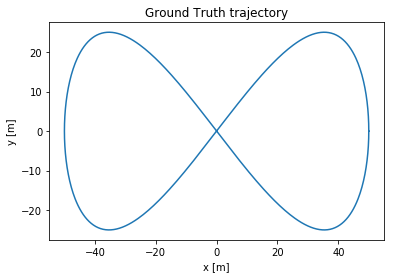

In [67]:
gt_fig = plt.figure()
ax = gt_fig.add_subplot(111)
ax.plot(x_true, y_true)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('Ground Truth trajectory')
plt.show()

Now that our data is loaded, we can start getting things ready for our solver. One of the
most important aspects of a filter is setting the input andmeasurement noise covariance matrices, as well as the initial state and covariance values. We set the values here:

In [68]:
v_var = 0.01  # translation velocity variance
om_var = 0.01  # rotational velocity variance
r_var = 0.1  # range measurements variance
b_var = 0.1  # bearing measurement variance

Q = np.diag([v_var, om_var]) # input noise covariance
R = np.diag([r_var, b_var])  # measurement noise covariance

x_est = np.zeros([len(v), 3])  # estimated states, x, y, and theta
P_est = np.zeros([len(v), 3, 3])  # state covariance matrices

x_est[0] = np.array([x_true[0], y_true[0], th_true[0]]) # initial state
P_est[0] = np.diag([1, 1, 0.1]) # initial state covariance


## Measurement update
-----
First, let's implement the measurement update function, which takes an available landmark measurement $l$ and updates the current state estimate $\mathbf{\check{x}}_k$.
For each landmark measurement in a given timestep $k$ you should implement the following steps:

\begin{align}
\mathbf{K}_k &= \mathbf{\check{P}}_k \mathbf{H}_k^T \left(\mathbf{H}_k \mathbf{\check{P}}_k \mathbf{H}_k^T + \mathbf{M}_k \mathbf{R}_k \mathbf{M}_k^T \right)^{-1} \\
\mathbf{\check{y}}^l_k &= \mathbf{h}_k\left(\mathbf{\check{x}}_k, \mathbf{0}\right) \\
\mathbf{\hat{x}}_k &= \mathbf{\check{x}} + \mathbf{K}_k \left(\mathbf{y}^l_k - \mathbf{\check{y}}^l_k\right)\\
\mathbf{\hat{P}}_k &= \left(\mathbf{1} - \mathbf{K}_k \mathbf{H}_k \right)\mathbf{\check{P}}_k
\end{align}

In [122]:
def wraptopi(x):
    if x > np.pi:
        x = x - (np.floor(x / (2 * np.pi)) + 1) * 2 * np.pi
    elif x < -np.pi:
        x = x + (np.floor(x / (-2 * np.pi)) + 1) * 2 * np.pi
    return x

# TODO Implement this function, which should compute and return the measurement Jacobian
# H_k with respect to the state, x.
# params: xl - the x position of the input landmark.
#         yl - the y position of the input landmark.
#         x  - the current estimated state.
def measurement_jacobian(xl, yl, x):
    G2 = (yl-x[1]-d*np.sin(x[2]))[0]
    G1 = (xl-x[0]-d*np.cos(x[2]))[0]
    G = np.sqrt((G1)**2 + (G2)**2)
    
    h1 = (-1*G1) / G
    h2 = (-1*G2) / G
    h3 = (d*np.sin(x[2])*(G1) - d*np.cos(x[2])*G2) / G

    den = 1 / (G1**2 + G2**2)
    
    h4 = G2 * den
    h5 = -1 * G1 * den
    h6 = (-G1*d*np.cos(x[2]) - G2*d*np.sin(x[2])) * den - 1

    h_jac=np.array([[h1,h2,h3],[h4,h5,h6]])

    return h_jac

# TODO Implement this function, which performs the Kalman update using the equations
# above.
# params: lk      - the array corresponding to the (x, y) coordinates of the landmark.
#         rk      - the current range measurement.
#         bk      - the current bearing measurement.
#         P_check - the current covariance estimate.
#         x_check - the current estimated state.
def measurement_update(lk, rk, bk, P_check, x_check):
    # 3.1 Compute measurement Jacobian using the landmarks and the current estimated state.
    H = measurement_jacobian(lk[0], lk[1], x_check)
    
    # 3.2 Compute the Kalman gain. 
    I2 = np.identity(2)
    I3 = np.identity(3)
    
    K = np.dot(np.dot(P_check,np.transpose(H)),np.linalg.inv((np.dot(np.dot(H,P_check),np.transpose(H)) + np.dot(np.dot(I2,R),np.transpose(I2)))))
   
    # 3.3 Correct the predicted state.
    # NB : Make sure to use wraptopi() when computing the bearing estimate!
    G2 = (lk[1]-x_check[1]-d*np.sin(x_check[2]))
    G1 = (lk[0]-x_check[0]-d*np.cos(x_check[2]))
        
    y_check=np.array([np.sqrt(G1**2+G2**2)[0],(wraptopi(np.arctan2(G2,G1)-x_check[2]))[0]])       
    
    y = np.array([rk, bk])
  
    x_check = x_check + np.dot(K,(y - y_check))    
    
    P_check = np.dot((I3 - np.dot(K,H)),P_check)

    return x_check, P_check


## Main loop
-----
Now, implement the main filter loop, implementing the prediction step of the EKF using the provided motion model:

\begin{align}
\mathbf{\check{x}}_k &= \mathbf{f}\left(\mathbf{\hat{x}}_{k-1}, \mathbf{u}_{k-1}, \mathbf{0} \right) \\
\mathbf{\check{P}}_k &= \mathbf{F}_{k-1}\mathbf{\hat{P}}_{k-1}\mathbf{F}_{k-1}^T + \mathbf{L}_{k-1}\mathbf{Q}_{k-1}\mathbf{L}_{k-1}^T \, .
\end{align}

Where

\begin{align}
\mathbf{F}_{k-1} = \frac{\partial \mathbf{f}}{\partial \mathbf{x}_{k-1}}\bigg|_{\mathbf{\hat{x}}_{k-1},\mathbf{u}_{k},0}  \, , \, \, \, \,
\mathbf{L}_{k-1} = \frac{\partial \mathbf{f}}{\partial \mathbf{w}_{k}}\bigg|_{\mathbf{\hat{x}}_{k-1},\mathbf{u}_{k},0} \, .
\end{align}

In [126]:
# TODO Implement the main kalman filter loop, using the above equations.
# Make use of the measurement_update() function defined above.
#### 5. Main Filter Loop #######################################################################



for k in range(1, len(t)):  # Start at 1 because we have initial prediction from ground truth.

    delta_t = t[k] - t[k - 1]  # time step (difference between timestamps)

    # 1. Update the state with IMU input.
    # NB : Make sure to use wraptopi() when computing the state heading!
    xno=x_est[k-1][0];yno=x_est[k-1][1];tno=x_est[k-1][2]  
    x_check=(x_est[k-1])+delta_t*np.dot(np.array([[np.cos(tno),0],[np.sin(tno),0],[0,1]]),(np.array([v[k],om[k]])));
    x_check[2]=wraptopi(x_check[2])
    # 1.1 Linearize Motion Model
    # Compute the Jacobian of f w.r.t. the last state.
    #
    
    f1=np.array([1,0,-delta_t*np.sin(tno)*v[k]])
    f2=np.array([0,1,delta_t*np.cos(tno)*v[k]])
    f3=np.array([0,0,1]);
    F=np.array([f1,f2,f3]);
    

    # Compute the Jacobian w.r.t. the noise variables.
    L = np.array([[delta_t*np.cos(tno),0],[delta_t*np.sin(tno),0],[0,delta_t]])
    
    # 2. Propagate uncertainty by updating the covariance.
    P_check = np.dot(np.dot(F,P_est[k-1]),np.transpose(F))+np.dot(np.dot(L,Q),np.transpose(L))

    # 3. Update state estimate using available landmark measurements r[k], b[k].
    for i in range(len(r[k])):
        
        x_check, P_check = measurement_update(l[i],r[k][i],b[k][i],P_check,x_check)
        
    # Set final state predictions for this kth timestep.
    print('time:',k,x_est[k])
    x_est[k] = x_check
    P_est[k] = P_check


time: 1 [49.98106542  0.62430325  1.6279965 ]
time: 2 [50.00568608  1.24661763  1.68362533]
time: 3 [49.94796601  1.84851419  1.7383868 ]
time: 4 [49.8797284   2.48042375  1.8079126 ]
time: 5 [49.93126526  3.10605154  1.73611076]
time: 6 [49.87103055  3.80332445  1.69745692]
time: 7 [49.82941622  4.4919058   1.76849291]
time: 8 [49.77161146  5.01936421  1.7524463 ]
time: 9 [49.71453911  5.57206523  1.83172251]
time: 10 [49.56636822  6.20744596  1.77732099]
time: 11 [49.52618107  6.79691092  1.77816752]
time: 12 [49.44943435  7.36307843  1.7651123 ]
time: 13 [49.33187413  7.90274271  1.77441476]
time: 14 [49.21123777  8.58243672  1.83115434]
time: 15 [49.14148573  9.20905016  1.73013331]
time: 16 [48.99105355  9.80286995  1.76847698]
time: 17 [48.87352545 10.44601356  1.75662535]
time: 18 [48.75208198 11.06304884  2.2012647 ]
time: 19 [48.56064774 11.60530307  2.32452909]
time: 20 [48.43982568 12.01369907  2.17381962]
time: 21 [48.28702566 12.5729776   1.9712274 ]
time: 22 [48.07839565 

time: 195 [-38.59538436 -24.30793767   2.81106233]
time: 196 [-39.00435954 -24.18405428   2.73416583]
time: 197 [-39.35143247 -24.09880308   2.86438824]
time: 198 [-39.73684329 -24.01773355   2.77369284]
time: 199 [-40.07701067 -23.83909507   2.74588497]
time: 200 [-40.46113049 -23.6563238    2.68988094]
time: 201 [-40.88631012 -23.51927427   2.71147196]
time: 202 [-41.12537149 -23.30488672   2.62097128]
time: 203 [-41.5599877  -23.11246011   2.55206474]
time: 204 [-41.90195992 -22.80906534   2.50892483]
time: 205 [-42.27589502 -22.58528167   2.48982348]
time: 206 [-42.58485048 -22.30070768   2.48401197]
time: 207 [-42.87199147 -22.05132772   2.45731756]
time: 208 [-43.14142353 -21.75148889   2.42911144]
time: 209 [-43.56091113 -21.43636958   2.36099619]
time: 210 [-43.80659195 -21.10269366   2.24473786]
time: 211 [-44.08453247 -20.81489161   2.30679848]
time: 212 [-44.39181831 -20.39104778   2.28139868]
time: 213 [-44.70215174 -19.97853257   2.18082342]
time: 214 [-44.96921547 -19.636

time: 395 [ 12.4367048  -11.98653828  -0.72435104]
time: 396 [ 13.0503017  -12.56259468  -0.75224234]
time: 397 [ 13.67295301 -13.11153877  -0.78904509]
time: 398 [ 14.26027724 -13.61482218  -0.74805386]
time: 399 [ 14.86610846 -14.23748344  -0.69273631]
time: 400 [ 15.44600774 -14.78705518  -0.65377457]
time: 401 [ 16.03700451 -15.22251354  -0.59901715]
time: 402 [ 16.6186673  -15.62515855  -0.5875139 ]
time: 403 [ 17.25901886 -16.09937686  -0.71093134]
time: 404 [ 17.84875239 -16.65115023  -0.66918083]
time: 405 [ 18.4106314  -17.14752766  -0.68112758]
time: 406 [ 19.00220144 -17.56377147  -0.70312732]
time: 407 [ 19.56056804 -18.00993369  -0.67467805]
time: 408 [ 20.12672264 -18.52608361  -0.58157003]
time: 409 [ 20.70411231 -18.92276461  -0.6640318 ]
time: 410 [ 21.25351994 -19.33226273  -0.62309088]
time: 411 [ 21.84831388 -19.69328263  -0.66042893]
time: 412 [ 22.37516282 -20.11656897  -0.58181881]
time: 413 [ 22.95952121 -20.4321927   -0.58862967]
time: 414 [ 23.52962941 -20.748

Let's plot the resulting state estimates:

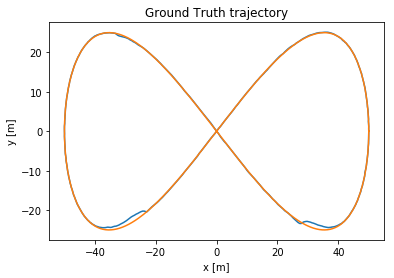

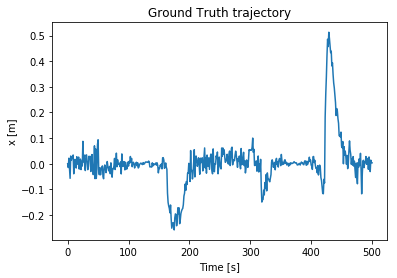

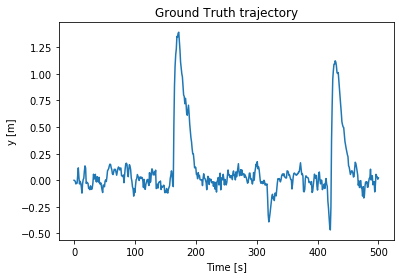

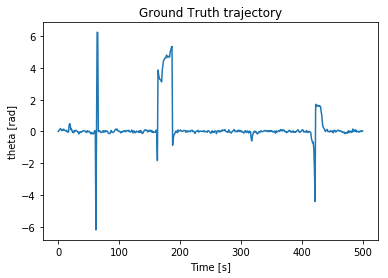

In [124]:
gt_fig = plt.figure()
ax = gt_fig.add_subplot(111)
ax.plot(x_est[:, 0], x_est[:, 1])
ax.plot(x_true[:], y_true[:])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('Ground Truth trajectory')
plt.show()

x_fig = plt.figure()
ax = x_fig.add_subplot(111)
ax.plot(t, (x_est[:, 0]-x_true))
ax.set_xlabel('Time [s]')
ax.set_ylabel('x [m]')
ax.set_title('Ground Truth trajectory')

y_fig = plt.figure()
ax = y_fig.add_subplot(111)
ax.plot(t, (x_est[:, 1]-y_true))
ax.set_xlabel('Time [s]')
ax.set_ylabel('y [m]')
ax.set_title('Ground Truth trajectory')

th_fig = plt.figure()
ax = th_fig.add_subplot(111)
ax.plot(t, (x_est[:, 2]-th_true))
ax.set_xlabel('Time [s]')
ax.set_ylabel('theta [rad]')
ax.set_title('Ground Truth trajectory')
plt.show()



The plotted trajectory should match the ground truth. Congratulations! Assignment complete.